# Signal processing in FTIR spectroscopy

The FTIR spectrometer does not directly record a spectrum, but an interferogram. Before display and further analysis by the analytical chemist this interferogram is [Fourier transformed](https://en.wikipedia.org/wiki/Fourier_transform). 

Typically, the interferogram is modified numerically before the Fourier transform is calculated. By multiplying the interferogram with a window function or "apodization" oscillation around sharp bands can be removed. Zero filling (i.e. adding zeros at the end of the interferogram) improves the apparent spectral resolution by interpolating between points. 

The image below contains a spectrum with multiple sharp lines (similar to the mid-IR spectrum of a gaseous molecule). You can adjust actual resolution, window function and the zero filling factor.  

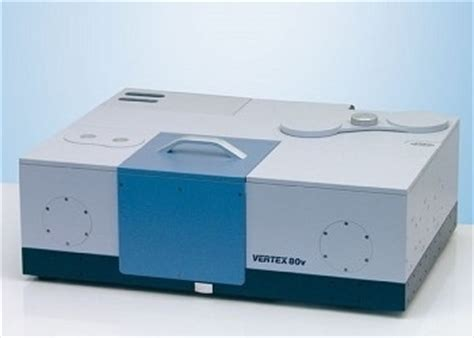

## Experiments:

1. Adjust the resolution and see how the number of recorded data points changes.
2. Reduce the resolution until oscillations start to appear on the base line. How does the interfergram look at this point?
3. At this resolution: zoom in on a single band and change the window function. What are advantages and draw backs **boxcar** and **Blackman-Harris** window functions?
4. Set the resolution to 2 $\mathrm{cm^{-1}}$. How does changing the zero filling factor change the interferogram?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import ipywidgets as widgets
import mpl_interactions.ipyplot as iplt
import mpl_interactions
from scipy.signal import get_window


%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

from functools import lru_cache, wraps
%matplotlib widget

In [2]:

def lorentz_ft(delta_l,A, m, w):
    f = 2*np.pi*delta_l
    return A*np.exp(-np.abs(f*w)/2)*np.exp(-1j*m*f)

def lorentzian(x, A, m, w):
    return A/(2*np.pi)*w/((x-m)**2 + (1/2*w)**2)

def interferogram(res, fun, fft_shift=True):
    # res: resolution in 1/cm
    spacing = .633E-7 * 5000# cm
    delta_l = np.arange(0,1/res, spacing)
    delta_l = np.concatenate([delta_l[:-1], -delta_l[-1:0:-1]])
    if not fft_shift:
        delta_l = np.fft.fftshift(delta_l)
    return delta_l, fun((delta_l))*2/res


def gas(B, T, bandshape, A0, m0,w,  max_J=6, compl=True):
    scaling = 6.626E-34 *3E9 /1.38E-23
    def fun(x):
        if compl:
            out = np.zeros(len(x), dtype=complex)
        else:
            out = np.zeros(len(x), dtype=float)
        for J in range(1,max_J):
            scale = (2*J+1)*np.exp(-B/T*scaling *J*(J+1))
            out += bandshape(x,A0*scale, m0+(J)*B/100, w)
            if J > 1:
                out += bandshape(x,A0*scale, m0-(J-1)*B/100, w)
        return out
    return fun



In [3]:
class Filter_Visualize:
    def __init__(self, fun_ft, fun=None, res=.01, max_wn=4000):
        """
        Hide ugly details for visualizing effects of filters, zerofilling etc for FTIR
        
        Parameters:
        -------------
        
        fun_ft : function that takes delta_l (in cm) input and returns (complex) amplitude
        
        fun : function that takes wavenumber input and returns (real) amplitude in wavenumber domain
        
        res : required resolution (in cm-1)
        
        max_wn : maximum wavenumber (in cm-1)
        """
        self.fun = fun
        self.fun_ft = fun_ft
        self.spacing = 633E-7*np.floor(.5/(max_wn*633E-7))
        self.res = res
        
    def attr_exists_and_set(self, attr):
        if not hasattr(self, attr):
            return False
        return getattr(self,attr)  is not None
            
    @property
    def N(self):
        if not self.attr_exists_and_set("_N"):
            self._N = len(self.delta_l)
        return self._N
        
    
    @property
    def delta_l(self):
        if not self.attr_exists_and_set("_delta_l"):
            delta_l = np.arange(0,1/self.res, self.spacing)
            self._delta_l = delta_l
        return self._delta_l
    
    @property
    def wn(self):
        if not self.attr_exists_and_set("_wn"):
            self._wn = np.abs(np.fft.fftfreq(len(self.delta_l)*2, 
                                             self.delta_l[1] - self.delta_l[0])
                                             [0:self.N])
        return self._wn
    
    @property
    def full_ft(self):
        if not self.attr_exists_and_set( "_full_ft"):
            self._full_ft = self.fun_ft(self.delta_l)*2/self.res
        return self._full_ft

    @property
    def full(self):
        if not self.attr_exists_and_set("_full"):
            if not self.attr_exists_and_set("fun"):
                self._full = sp.fft.idct(self.full_ft.real)
            else:
                self._full = self.fun(self.wn)
        return self._full     
    
    def resampled_N(self, res):
        return int(np.ceil(self.res/res*self.N))
    
    def res_from_N(self, N):
        return 1/(self.spacing*N)
    
    def undersampled_ft(self, res):
        N = self.resampled_N(res)
        return self.full_ft[:N]
    
    def resampled_delta_l(self, res=None, N=None):
        if res is not None:
            N = self.resampled_N(res)
        return self.spacing*np.arange(N)
    
    def resampled_wn(self, res=None, N=None):
        if res is not None:
            N = self.resampled_N(res)
        return (np.arange(N))/(N*self.spacing*2)
    
    def undersampled(self, res):
        N = self.resampled_N(res)
        res = self.res_from_N(N)
        return sp.fft.idct(self.undersampled_ft(res).real)/res*self.res
    
    def window(self, window_function,length=None, ft_data=None):
        """
        window : "boxcar", "triang", "blackmanharris"

        """
        if length is None:
            length = len(ft_data)
        M = 2*length
        window = np.fft.fftshift(get_window(window_function, M))
        return window[:length]
    
    def zero_fill(self, ft_data, zero_filling_factor):
        return np.concatenate((ft_data, np.zeros(len(ft_data)*(zero_filling_factor - 1))))
    
    def undersampled_windowed_ft(self, res, zero_filling_factor=1, window_function="boxcar"):
        ft_data = self.undersampled_ft(res)
        window_fun = self.window(window_function, ft_data = ft_data)
        ft_data = ft_data*window_fun
        data_zero_filled = self.zero_fill(ft_data, zero_filling_factor)
        return data_zero_filled
    
    def undersampled_windowed_window(self, res, zero_filling_factor=1, window_function="boxcar"):
        ft_data = self.undersampled_ft(res)
        window_fun = self.window(window_function, ft_data = ft_data)
        ft_data = window_fun
        data_zero_filled = self.zero_fill(ft_data, zero_filling_factor)
        return data_zero_filled
    
    def undersampled_windowed_delta_l(self, res, zero_filling_factor=1, window_function="boxcar"):
        return self.resampled_delta_l(N= self.resampled_N(res) * (zero_filling_factor))
    
    def undersampled_windowed_wn(self, res, zero_filling_factor=1, window_function="boxcar"):
       
        return self.resampled_wn(N= self.resampled_N(res) * (zero_filling_factor))
    
    def undersampled_windowed(self, res,  zero_filling_factor=1, window_function="boxcar"):
        idct = sp.fft.idct(
            self.undersampled_windowed_ft(res=res, 
            zero_filling_factor=zero_filling_factor, 
            window_function=window_function))
        return idct /self.res_from_N(len(idct))*self.res
    
def dbl_ft(data, freq=False):
    scale = 1
    if freq:
        scale = -1
    return np.concatenate((scale*data[-1:0:-1], data[0:]))

def dbl_ft_wrap(fun, freq=False):
    @wraps(fun)
    def wrapper(*args, **kwargs):
        return dbl_ft(fun(*args, **kwargs), freq=freq)
    return wrapper

def de_x(fun):
    @wraps(fun)
    def wrapper(*args, **kwargs):
        fval = fun(*args[1:], **kwargs)
        return fval
    return wrapper

def real(fun):
    @wraps(fun)
    def wrapper(*args, **kwargs):
        fval = fun(*args, **kwargs)
        return fval.real
    return wrapper

In [4]:
#fun = gas(300, 300, lorentzian, .01, 1000, .05, 10)
fun_ft = gas(100, 300, lorentz_ft, .01, 1000, .05, 10)

In [5]:
filter_vis = Filter_Visualize(fun_ft, res=.01, max_wn=1200)

In [6]:
plt.close("all")

In [40]:
layout = widgets.Layout(width="auto")
style = {'description_width': '120pt'}
controls = mpl_interactions.controller.Controls()
controls.add_kwargs({"res":widgets.FloatLogSlider(value=.01, 
                                                 base=10, 
                                                 min=-2, 
                                                 max=1, 
                                                  readout_format=".2f", 
                                                 description="Spectral Resolution [cm$^{-1}$]",
                                                 style=style, layout=layout),
                    "window_function":widgets.Dropdown(options=
                                        [("boxcar","boxcar"), ("triangular","triang"), ("Blackman-Harris","blackmanharris")], 
                                                       description="Window function",
                                                      style=style, layout=layout), 
                    "zero_filling_factor":widgets.IntSlider(value=1, min=1, max=16,
                                                            description="Zero filling factor",style=style, layout=layout)})

In [41]:
plt.ioff()
fig1, ax_ft = plt.subplots(1, squeeze=True, constrained_layout=True, figsize=None)
fig2, ax_real = plt.subplots(1, squeeze=True, constrained_layout=True, figsize=None)




ax_ft.plot(dbl_ft(filter_vis.delta_l, True), dbl_ft(filter_vis.full_ft.real))
ax_window = ax_ft.twinx()

iplt.plot(dbl_ft_wrap(filter_vis.undersampled_windowed_delta_l, True),
           real(de_x(dbl_ft_wrap(filter_vis.undersampled_windowed_ft))),
                     controls=controls,ax=ax_ft,
                    xlim="fixed")




iplt.plot(dbl_ft_wrap(filter_vis.undersampled_windowed_delta_l, True),
           real(de_x(dbl_ft_wrap(filter_vis.undersampled_windowed_window))), 
          ax=ax_window,
          color="gray",
          linewidth=2,
          controls=controls, ylim=[-1.1,1.1], 
         label="window function")

ax_window.set_yticks([])

ax_real.plot(filter_vis.wn, filter_vis.full, label="full resolution")


iplt.plot(filter_vis.undersampled_windowed_wn,
           real(de_x(filter_vis.undersampled_windowed)), 
            label="filtered",
              ax=ax_real,
          controls=controls,
         xlim=(980, 1020))

ax_real.set_xlabel(r"$\mathrm{\tilde{\nu}}$ / $\mathrm{cm^{-1}}$")
ax_real.set_ylabel("Intensity / a.u.")
ax_real.set_yticks([])

ax_real.set_xlim(980, 1020)
handles_labels = []


ax_ft.set_xlabel(r"$\mathrm{\Delta l}$ / cm")
ax_ft.set_ylabel("Intensity / a.u.")
ax_ft.set_yticks([]);

In [42]:
from itertools import chain
fig3=plt.figure( constrained_layout=True, figsize=(2,1))
w, h = list(zip(*chain.from_iterable(zip(*ax.get_legend_handles_labels()) for ax in [ax_real, ax_window])))
fig3.legend(w, h)
fig3.canvas.header_visible=False
fig3.canvas.toolbar_visible =False
fig3.canvas.width ="auto"
fig3.canvas.min_width ="50px"

footer = widgets.VBox([controls.vbox, fig3.canvas])
footer.layout.display = "flex"
footer.layout.justify_content ="space-around"
footer.layout.flex_flow = "row wrap"

In [44]:
for f in [fig1, fig2]:
    f.set_size_inches(5, 4, True)
    f.canvas.resizable = False
    f.canvas.header_visible=False
    #f.canvas.layout.border = '1px solid black'
    f.canvas.layout.min_width = '100px'
    #f.canvas.layout.min_height = '100px'
    f.canvas.layout.width = 'auto'
    #f.canvas.layout.height = 'auto'
    #f.canvas.layout.flex='1 1 auto'
    #f.canvas.layout.width = 'auto'
    f.canvas.layout.justify_content ="center"
   
    
fig_box = widgets.HBox([fig1.canvas, fig2.canvas,], )
fig_box.layout.display = 'flex'
fig_box.layout.flex_flow = "row wrap"
fig_box.layout.justify_content = "space-around"

#widgets.AppLayout(center=fig_box, 
#                  footer=footer,
#                  merge=True, width="100%")

In [46]:
display(fig1.canvas)

Canvas(header_visible=False, layout=Layout(justify_content='center', min_width='100px', width='auto'), resizab…

In [47]:
display(fig2.canvas)

Canvas(header_visible=False, layout=Layout(justify_content='center', min_width='100px', width='auto'), resizab…

In [48]:
display(fig3.canvas)

Canvas(header_visible=False, toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Bac…

In [64]:
display(controls)